# 7. Finetuning of the models

---
**To be able to execute this notebook, please download your own local version of the data from https://www.kaggle.com/martinellis/nhl-game-data and store it into the folder "data/nhl/nhl_stats/"**



**In addition, please download your own local version of the data from https://www.kaggle.com/camnugent/predict-nhl-player-salaries and store it into the folder "data/nhl/nhl_salaries/"**

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import math
import time

from numpy import sqrt
from numpy import argmax

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA


from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
from matplotlib import patches

from utils import create_dummy_df
from utils import plot_correlation_matrix
from utils import balance_binary_target

from models import run_logistic_regression
from models import run_lightgbm_classifier
from models import run_kneighbors_classifier

from metrics import save_metrics
from metrics import plot_metrics
from metrics import init_metrics_file
from metrics import evaluate_model

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sns.set()

---
## Preparing data used in the previous sections

In [2]:
df = pd.read_parquet('data/benchmark.parquet')

In [4]:
_, lg = run_logistic_regression(df, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df, c_matrix=False, r_curve=False);

========== Logistic Regression ==========
Accuracy: 0.5512
F1 Score: 0.4967
AUC-ROC Score: 0.5813
-----------------------------------------
Precision: 0.5676
Recall: 0.4416
========== LightGBM Classifier ==========
Accuracy: 0.6973
F1 Score: 0.7118
AUC-ROC Score: 0.7604
-----------------------------------------
Precision: 0.6812
Recall: 0.7453


In [2]:
# read data
df_game_plays = pd.read_csv('data/nhl/nhl_stats/game_plays.csv')
df_game_plays.drop_duplicates(inplace=True)

# drop NaNs, select relevant columns only
df = df_game_plays[['play_id', 'event', 'secondaryType', 'st_x', 'st_y', 'period', 'periodTime']][(df_game_plays.event=='Goal') | (df_game_plays.event=='Shot')]
df.dropna(inplace=True)
df.secondaryType = df.secondaryType.str.replace(" ", "")
df.secondaryType = df.secondaryType.str.replace("-", "")

# Prepare target. Convert categorical event values 'Goal' to a numerical 0/1 value indicating goal
df['goal'] = np.where(df.event=='Goal', 1, 0)
df.drop(columns='event', inplace=True)

# Convert categorical 'secondaryType' column to multiple numerical columns
cat_cols = ['secondaryType']
df = create_dummy_df(df=df, cat_cols=cat_cols, dummy_na=True)
df.drop(columns=['secondaryType_nan'], inplace=True)

#balance targets (under-sampling)
df = balance_binary_target(df, target='goal')

In [3]:
# adding feature distance
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)

df_data_dist = df.copy()
df_data_dist['distance'] = df_data_dist.apply(dist, axis=1)

# cut outliers first
df_data_dist = df_data_dist[df_data_dist.distance<100]

In [4]:
# adding feature angle
def angle(df):     
    middle_goal_x = 100 
    return math.fabs(math.degrees(math.atan2(df.st_x - middle_goal_x, df.st_y)) + 90)

df_data_dist_angle = df_data_dist.copy()
df_data_dist_angle['angle'] = df_data_dist_angle.apply(angle, axis=1)

# cutting outliers
df_data_dist_angle= df_data_dist_angle[df_data_dist_angle.angle<70]

---
## Adding players to game events

In [5]:
df_player = pd.read_csv('data/nhl/nhl_stats/game_plays_players.csv')
df_player.drop_duplicates(inplace=True)

---
Read and filter the data frame twice, once for skate, once for goalie:

In [6]:
df_skater = df_player[df_player.playerType.isin(['Shooter', 'Scorer'])].copy()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater.drop(columns=['game_id', 'playerType'], inplace=True)

df_goalie = df_player[df_player.playerType.isin(['Goalie'])].copy()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie.drop(columns=['game_id', 'playerType'], inplace=True)

---
Merge both player types with game plays:

In [7]:
# created new table and merge skaters and golies to the game events
df_data_player = df_data_dist_angle.copy()

df_data_player = df_data_player.merge(df_skater, how='left', on='play_id')
df_data_player = df_data_player.merge(df_goalie, how='left', on='play_id')

In [8]:
# Apparently not all shots were on goal. No golie then. Keeping this rows anyway but replacing goalie by Zero
df_data_player.goalie_id.fillna(0, inplace=True)

========== Logistic Regression ==========
Accuracy: 0.5156
F1 Score: 0.0628
AUC-ROC Score: 0.5204
-----------------------------------------
Precision: 0.9985
Recall: 0.0324
========== LightGBM Classifier ==========
Accuracy: 0.6928
F1 Score: 0.7087
AUC-ROC Score: 0.7539
-----------------------------------------
Precision: 0.6745
Recall: 0.7465
========= KNeighbors Classifier =========
Accuracy: 0.5245
F1 Score: 0.4926
AUC-ROC Score: 0.5381
-----------------------------------------
Precision: 0.5288
Recall: 0.4610


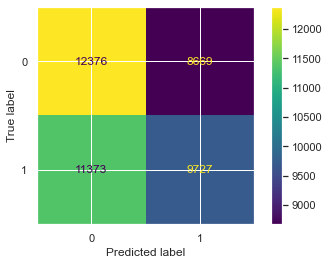

In [9]:
# starting training with player_id
_, lg = run_logistic_regression(df_data_player, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_data_player, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_data_player, c_matrix=True, r_curve=False);

## Adding player statistics

In [10]:
df_player_info = pd.read_csv('data/nhl/nhl_stats/player_info.csv')

---
Calculating overall savePercentage for each goalie:

In [11]:
df_goalie = pd.read_csv('data/nhl/nhl_stats/game_goalie_stats.csv')
df_goalie = df_goalie.groupby('player_id').agg({'savePercentage':'mean'}).reset_index()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)

---
Calculating overall statistics for each skater:

In [12]:
df_skater = pd.read_csv('data/nhl/nhl_stats/game_skater_stats.csv')
df_skater = df_skater.groupby('player_id').agg({'goals':'sum', 'shots':'sum', 'assists':'sum', 'timeOnIce':'sum'}).reset_index()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)

---
Merging it together in the training dataset

In [13]:
df_data_player = df_data_player.merge(df_skater, how='left', on='skater_id')
df_data_player = df_data_player.merge(df_goalie, how='left', on='goalie_id')

In [14]:
df_data_player.savePercentage.fillna(df_data_player.savePercentage.median(), inplace=True)
df_data_player.dropna(inplace=True)

In [15]:
run_logistic_regression(df_data_player, c_matrix=False, r_curve=False);
run_lightgbm_classifier(df_data_player, c_matrix=False, r_curve=False);

========== Logistic Regression ==========
Accuracy: 0.5518
F1 Score: 0.4990
AUC-ROC Score: 0.5843
-----------------------------------------
Precision: 0.5665
Recall: 0.4458
========== LightGBM Classifier ==========
Accuracy: 0.6953
F1 Score: 0.7105
AUC-ROC Score: 0.7582
-----------------------------------------
Precision: 0.6776
Recall: 0.7467


## Adding players salaries

In [15]:
# Data from another dataset
df_players_train = pd.read_csv('data/nhl/nhl_salaries/train.csv')
df_players_test = pd.read_csv('data/nhl/nhl_salaries/test.csv')

df_player_stats = pd.concat([df_players_train, df_players_test])

In [16]:
df_player_stats = df_player_stats[['First Name', 'Last Name', 'Nat', 'Salary']].rename(columns={'First Name':'firstName', 'Last Name':'lastName', 'Nat':'nationality', 'Salary':'salary'})

---
Prepare player_info for merging

In [17]:
df_player_info.rename(columns={'player_id':'skater_id'}, inplace=True)

---
Add additional player's identification data to the target dataset: 

In [18]:
#add name and nationality of the skater
df_data_player = df_data_player.merge(df_player_info[['skater_id', 'firstName', 'lastName', 'nationality']], how='left', on='skater_id')

---
Add salary to the merged dataset:

In [19]:
# add salary based on first name, last name, and the nationality
df_data_player = df_data_player.merge(df_player_stats, how='left', on=['firstName', 'lastName', 'nationality'])

___
Replace missing salary with median (to ignore outliers):

In [20]:
# replace missing salary
df_data_player.salary.fillna(df_data_player.salary.median(), inplace=True)

In [21]:
df_dataset = df_data_player.copy()

In [22]:
# cutting outliers
df_dataset = df_dataset[df_dataset.goals<400]
df_dataset = df_dataset[df_dataset.shots<4000]
df_dataset = df_dataset[df_dataset.assists<700]
df_dataset = df_dataset[df_dataset.salary<10000000]



## Re-train models to set benchmark

========== Logistic Regression ==========
Accuracy: 0.5557
F1 Score: 0.4797
AUC-ROC Score: 0.5885
-----------------------------------------
Precision: 0.5700
Recall: 0.4140


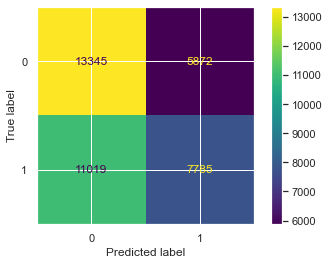

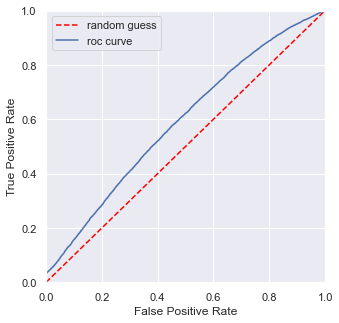

========== LightGBM Classifier ==========
Accuracy: 0.6996
F1 Score: 0.7088
AUC-ROC Score: 0.7601
-----------------------------------------
Precision: 0.6809
Recall: 0.7390


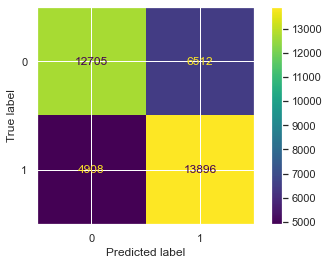

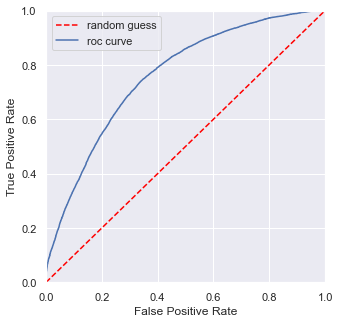

In [23]:
# starting training with player salary
run_logistic_regression(df_dataset, c_matrix=True, r_curve=True);
run_lightgbm_classifier(df_dataset, c_matrix=True, r_curve=True);

---
## Experiments with fine tuning
Different techniques will be applied to try to improve the models


---

#### Set training and test data for experiments

In [24]:
target = 'goal'
features = df_dataset.select_dtypes(exclude='object').columns.to_list()
features.remove(target)

X_train, X_test, y_train, y_test = train_test_split(df_dataset[features], df_dataset[target], test_size=0.3, random_state=42)

---

### Optimizing Logistic Regression

The logistic regression model is performing very pure. High Precision, Low Recall. Accuracy close to the random choice.

---
The target is balanced, shouldn't be a problem:

In [25]:
# what is the portion of the target 1 in the dataset?
df_dataset[df_dataset.goal==1].shape[0] / df_dataset.shape[0]

0.4923857467491478

---
Trying to use scaling of X data

Accuracy: 0.6931
F1 Score: 0.6991
AUC-ROC Score: 0.7517
-----------------------------------------
Precision: 0.6787
Recall: 0.7208


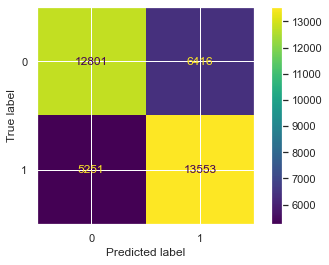

In [26]:
# create model
model = make_pipeline(StandardScaler(), 
                      LogisticRegression(max_iter=10000));
# fit model
model.fit(X_train,y_train)
#evaluate
evaluate_model(model, X_test, y_test, c_matrix=True, r_curve=False);

Looks much better now!!!  Scaler helped a lot!

---
Trying to change threshold to make it even better.

Best accuracy=0.6933536729702007 achieved with the threshold 0.4860000000000001
-----------------------------------------
Accuracy: 0.6934
F1 Score: 0.7039
AUC-ROC Score: 0.7517
-----------------------------------------
Precision: 0.6737
Recall: 0.7368


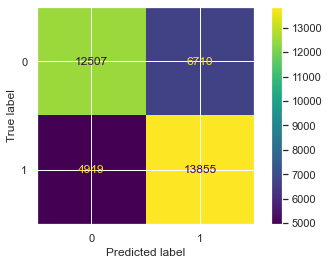

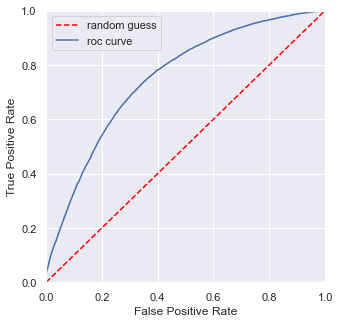

In [27]:
max_value = -1
best_threshold = 0
for thresh in np.arange(0.4, 0.6, 0.001):
    _, metrics = evaluate_model(model, X_test, y_test, threshold=thresh, c_matrix=False, r_curve=False, suppress=True);
    if metrics['accuracy'] > max_value: 
        max_value = metrics['accuracy']
        best_threshold = thresh
    
print(f'Best accuracy={max_value} achieved with the threshold {best_threshold}')
print('-----------------------------------------')

evaluate_model(model, X_test, y_test, threshold=best_threshold, c_matrix=True, r_curve=True);

There is almost no change at all now. Accuracy close to 0.7 is pretty good for the balanced dataset.

---
#### Trying just a small subset of features:

Accuracy: 0.6718
F1 Score: 0.6764
AUC-ROC Score: 0.7239
-----------------------------------------
Precision: 0.6602
Recall: 0.6934


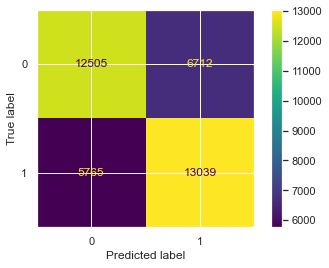

In [28]:
target = 'goal'
features2 = ['distance', 'angle', 'goals']

X_train2, X_test2, y_train2, y_test2 = train_test_split(df_dataset[features2], df_dataset[target], test_size=0.3, random_state=42)

# create model
model = make_pipeline(StandardScaler(), 
                      LogisticRegression(max_iter=10000));
# fit model
model.fit(X_train2,y_train2)
#evaluate
evaluate_model(model, X_test2, y_test2, c_matrix=True, r_curve=False);

not really a difference

---

#### How did perform of training data?

In [29]:
# create model
model = make_pipeline(StandardScaler(),
                      LogisticRegression(max_iter=10000));
# fit model
model.fit(X_train,y_train)
#evaluate
evaluate_model(model, X_train, y_train, c_matrix=False, r_curve=False);

Accuracy: 0.6909
F1 Score: 0.6941
AUC-ROC Score: 0.7520
-----------------------------------------
Precision: 0.6757
Recall: 0.7135


Pretty the same metric compared to test data. No indication of over fitting

---
### Optimizing LightGBM

---
LightGBM was performing much better than Logistic Regression at the beginning. Let's try similar steps to see what happens.

#### Using standard scaler for LightGBM

Accuracy: 0.6985
F1 Score: 0.7080
AUC-ROC Score: 0.7590
-----------------------------------------
Precision: 0.6794
Recall: 0.7391


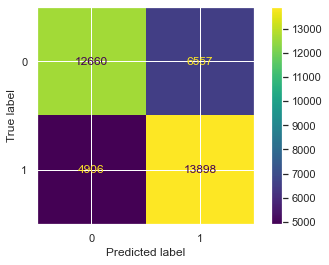

In [30]:
# create model
model = make_pipeline(StandardScaler(), LGBMClassifier(random_state=42));
# fit model
model.fit(X_train,y_train)
# evaluate
evaluate_model(model, X_test, y_test, c_matrix=True, r_curve=False);

This is actually almost the same

---

Best accuracy=0.6986928276478788 achieved with the threshold 0.5130000000000001
-----------------------------------------
Accuracy: 0.6987
F1 Score: 0.7041
AUC-ROC Score: 0.7590
-----------------------------------------
Precision: 0.6846
Recall: 0.7247


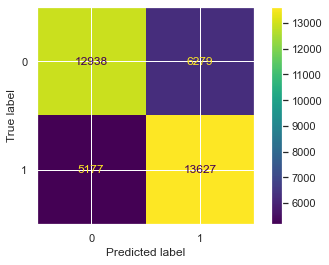

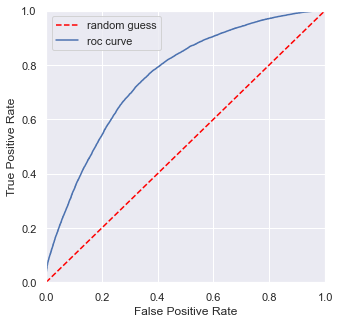

In [31]:
max_value = -1
best_threshold = 0
for thresh in np.arange(0.4, 0.6, 0.001):
    _, metrics = evaluate_model(model, X_test, y_test, threshold=thresh, c_matrix=False, r_curve=False, suppress=True);
    if metrics['accuracy'] > max_value: 
        max_value = metrics['accuracy']
        best_threshold = thresh
    
print(f'Best accuracy={max_value} achieved with the threshold {best_threshold}')
print('-----------------------------------------')

evaluate_model(model, X_test, y_test, threshold=best_threshold, c_matrix=True, r_curve=True);

This is slightly improvement compared to the benchmark but not too much.

---
#### How would it perform on training data?

In [32]:
# create model
model = LGBMClassifier(random_state=42);
# fit model
model.fit(X_train,y_train)
# evaluate
evaluate_model(model, X_train, y_train, c_matrix=False, r_curve=False);

Accuracy: 0.7087
F1 Score: 0.7156
AUC-ROC Score: 0.7810
-----------------------------------------
Precision: 0.6878
Recall: 0.7457


Very comparable.

---
#### Ad-hoc parameters selection for LGBM and cross-validation

In [33]:
grid_params = {'boosting_type': ['gbdt'], 
          'colsample_bytree': [0.75, 0.8, 0.85], 
          'learning_rate': [0.05, 0.1, 0.15], 
          'max_depth': [4, 5, 6], 
          'n_estimators': [80, 100, 120], 
          'num_leaves': [12, 18, 24], 
          'objective': ['binary'], 
          'reg_alpha': [4, 5, 6], 
          'reg_lambda': [4, 5, 6], 
          'seed': [500, 600, 700], 
          'subsample': [0.75]}

model = LGBMClassifier();
grid = GridSearchCV(model, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1)

# start trainig
start = time.time()
print(f'Starting...')

#grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

#model.fit(X_train,y_train)
duration = time.time() - start
print(f'Training ran in {duration:.5f} seconds')    

#mod, metrs = evaluate_model(grid, X_test, y_test)

Starting...


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

Compared to the benchmark, a small improvement of the metrics

----------------------------------------